In [71]:
!pip install unidecode

In [179]:
import json

# read file
with open('conala-train.json', 'r') as myfile:
    data=myfile.read()

# parse file
obj = json.loads(data)

train_intent_list = []
for i in range(len(obj)):
    train_intent_list.append(obj[i]['intent'])

train_snipet_list = []
for i in range(len(obj)):
    train_snipet_list.append(obj[i]['snippet'])

train_question_id_list = []
for i in range(len(obj)):
    train_question_id_list.append(obj[i]['question_id'])


In [180]:
train_intent_list[-1]

'Convert a string to datetime object in python'

In [181]:
train_snipet_list[-1]

"dateobj = datetime.datetime.strptime(datestr, '%Y-%m-%d').date()"

In [182]:
for item in range(len(train_snipet_list)):
    train_snipet_list[item] = " "+train_snipet_list[item]+" "

In [183]:
import numpy as np
import typing
from typing import Any, Tuple
import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
import tensorflow_text as tf_text
from nltk.translate.bleu_score import corpus_bleu

In [184]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [185]:
train_source_list = np.array(train_intent_list)

In [186]:
train_target_list = np.array(train_snipet_list)

In [187]:
train_source_list[:5]

array(['How to convert a list of multiple integers into a single integer?',
       'How to convert a list of multiple integers into a single integer?',
       'how to convert a datetime string back to datetime object?',
       'Averaging the values in a dictionary based on the key',
       'zip lists in python'], dtype='<U122')

In [188]:
train_target_list[:5]

array([' sum(d * 10 ** i for i, d in enumerate(x[::-1])) ',
       " r = int(''.join(map(str, x))) ",
       " datetime.strptime('2010-11-13 10:33:54.227806', '%Y-%m-%d %H:%M:%S.%f') ",
       ' [(i, sum(j) / len(j)) for i, j in list(d.items())] ',
       ' zip([1, 2], [3, 4]) '], dtype='<U234')

In [189]:
is_train = np.random.uniform(size=(len(train_source_list),)) < 0.8

In [190]:
is_train[:5]

array([ True,  True, False,  True,  True])

In [191]:
len(is_train)

2379

In [192]:
len(train_source_list)

2379

In [193]:
BUFFER_SIZE = len(train_source_list)
BATCH_SIZE = 20
train_raw = (
    tf.data.Dataset
    .from_tensor_slices((train_source_list[is_train], train_target_list[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((train_source_list[~is_train], train_target_list[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [194]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'from list of integers, get number closest to a given value'
 b'How to read stdin to a 2d python array of integers?'
 b'How to sort a dictionary in python by value when the value is a list and I want to sort it by the first index of that list'
 b'How do I print a Celsius symbol with matplotlib?'
 b'How to properly determine current script directory in Python?'], shape=(5,), dtype=string)

tf.Tensor(
[b' min(myList, key=lambda x: abs(x - myNumber)) '
 b' a.fromlist([int(val) for val in stdin.read().split()]) '
 b' sorted(list(data.items()), key=lambda x: x[1][0]) '
 b" ax.set_xlabel('Temperature ($^\\\\circ$C)') "
 b' os.path.dirname(os.path.abspath(__file__)) '], shape=(5,), dtype=string)


In [195]:
example_text = tf.constant(train_source_list[1])

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'How to convert a list of multiple integers into a single integer?'
b'How to convert a list of multiple integers into a single integer?'


In [196]:
example_text = tf.constant(train_target_list[1])

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b" r = int(''.join(map(str, x))) "
b" r = int(''.join(map(str, x))) "


In [197]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [200]:
def target_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text)
  text = tf.strings.join(['[START]', text, '[END]'])
  return text

In [201]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())
print(target_lower_and_split_punct(example_text).numpy().decode())

 r = int(''.join(map(str, x))) 
[START] r  int . joinmapstr ,  x [END]
[START] r = int(''.join(map(str, x))) [END]


In [210]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [211]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
len(context_text_processor.get_vocabulary())

1446

In [212]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=target_lower_and_split_punct,
    max_tokens=len(train_target_list),
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
len(target_text_processor.get_vocabulary())

2379

In [213]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 14, 11, 9, 106, 41, 18, 48, 795, 7, 4, 179, 30, 3],
 [2, 8, 7, 87, 492, 7, 4, 91, 6, 28, 9, 106, 10, 3],
 [2, 8, 7, 42, 4, 19, 5, 6, 24, 30, 185, 13, 30, 40, 4, 11, 33, 17, 607, 7,
  42, 134, 24, 13, 112, 56, 9, 108, 11, 3]                                 ]>

In [214]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[1].numpy()]
' '.join(tokens)

'[START] how to read stdin to a d python array of integers ? [END]'

In [215]:
target_vocab = np.array(target_text_processor.get_vocabulary())
tokens = target_vocab[example_tokens[1].numpy()]
' '.join(tokens)

"[START] if x result datetime.datetime.strptime('2013-1-25', x in ascending=[True, = 3, i except x: [END]"

Text(0.5, 1.0, 'Mask')

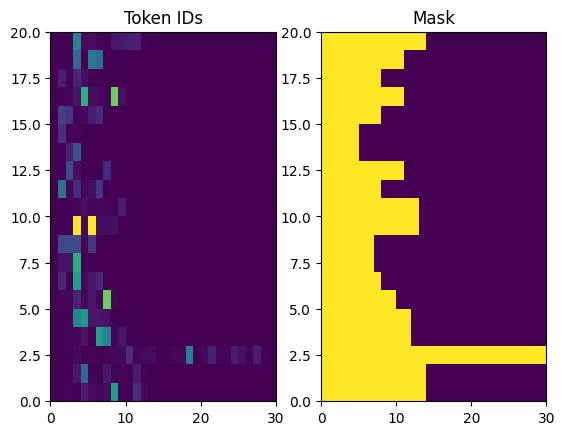

In [216]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [217]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [218]:
#Here is first sequence of each bach
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[  2   8   7 151  13 226   9 112 357   9]

[   2   32 1200   11 1199    0    0    0    0    0]
[  32 1200   11 1199    3    0    0    0    0    0]


In [219]:
UNITS = 232

In [220]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [221]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (20, 21)
Encoder output, shape (batch, s, units): (20, 21, 232)


In [222]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [223]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (20, 21, 232)
Target sequence, shape (batch, t, units): (20, 17, 232)
Attention result, shape (batch, t, units): (20, 17, 232)
Attention weights, shape (batch, t, s):    (20, 17, 21)


In [224]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ], dtype=float32)

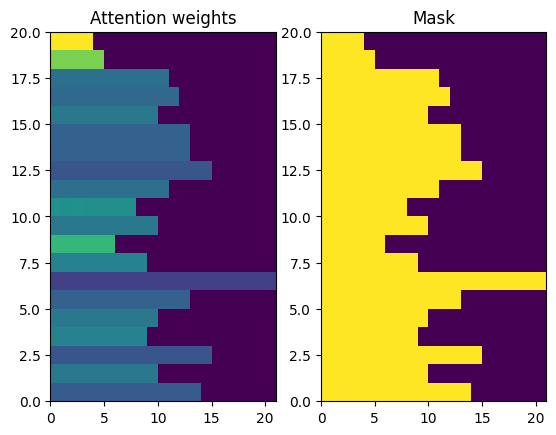

In [225]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


In [226]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [227]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [228]:
decoder = Decoder(target_text_processor, UNITS)

In [229]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (20, 21, 232)
input target tokens shape: (batch, t) (20, 17)
logits shape shape: (batch, target_vocabulary_size) (20, 17, 2379)


In [230]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [231]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [232]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

In [233]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'sorted(list_of_dct, sum((1 v.required] key=presorted_list.index) string.punctuation) numpy.dot(numpy.dot(a, y)).reshape(-1, map(sum, set([3, x.fillna(x.mean()),',
       b"x.split()] list] re.compile('^(.+)(?:\\\\n|\\\\r\\\\n?)((?:(?:\\\\n|\\\\r\\\\n?).+)+)', xor(bool(a), pd.concat([df.head(1), io.open('data.txt', sorted(s, s.split(':'), {{car.date_of_manufacture re.compile('.\\\\A|.\\\\A*|.\\\\A+')",
       b"i)) float))) sum(tup[1])) {'name': list(itertools.product(*a)) number) i] itertools.groupby(mylist, np.mean(np.array([old_set, insensitive)')"],
      dtype=object)

In [234]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [235]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (20, 21)
Target tokens, shape: (batch, t) (20, 17)
logits, shape: (batch, t, target_vocabulary_size) (20, 17, 2379)


In [236]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [237]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [238]:
#Configuring model for training:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [239]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 7.7744355, 'expected_acc': 0.0004203446826397646}

In [240]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 6s 27ms/step - loss: 7.7679 - masked_acc: 8.9744e-04 - masked_loss: 7.7679


{'loss': 7.767889022827148,
 'masked_acc': 0.000897435937076807,
 'masked_loss': 7.767889976501465}

In [242]:
history = model.fit(
    train_ds.repeat(), 
    epochs=20,
    steps_per_epoch = 20,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/20
20/20 [==============================] - 2s 95ms/step - loss: 5.1112 - masked_acc: 0.2344 - masked_loss: 5.1112 - val_loss: 3.6157 - val_masked_acc: 0.3588 - val_masked_loss: 3.6157
Epoch 2/20
20/20 [==============================] - 2s 99ms/step - loss: 4.9243 - masked_acc: 0.2935 - masked_loss: 4.9243 - val_loss: 3.2575 - val_masked_acc: 0.4503 - val_masked_loss: 3.2575
Epoch 3/20
20/20 [==============================] - 2s 97ms/step - loss: 4.7796 - masked_acc: 0.3298 - masked_loss: 4.7796 - val_loss: 3.1009 - val_masked_acc: 0.4884 - val_masked_loss: 3.1009
Epoch 4/20
20/20 [==============================] - 2s 94ms/step - loss: 4.5832 - masked_acc: 0.3630 - masked_loss: 4.5832 - val_loss: 3.0498 - val_masked_acc: 0.5113 - val_masked_loss: 3.0498
Epoch 5/20
20/20 [==============================] - 2s 94ms/step - loss: 4.4185 - masked_acc: 0.3901 - masked_loss: 4.4190 - val_loss: 2.7289 - val_masked_acc: 0.5146 - val_masked_loss: 2.7289
Epoch 6/20
20/20 [=================

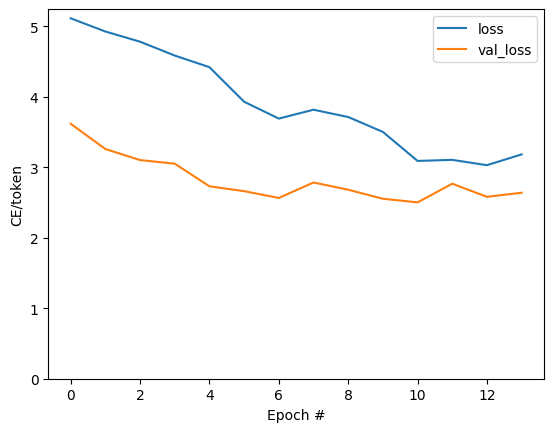

In [243]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

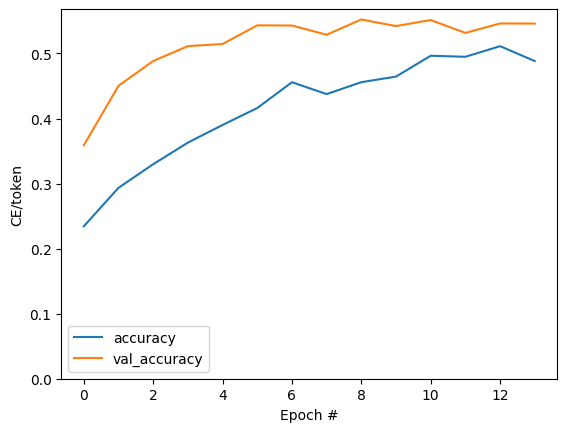

In [244]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [245]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [247]:
result = model.translate(['Find next sibling element in Python Selenium?'])
result[0].numpy().decode()

'[UNK] '

In [248]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output Command')

C:\Users\brije\AppData\Local\Temp\ipykernel_48444\43034453.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\brije\AppData\Local\Temp\ipykernel_48444\43034453.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


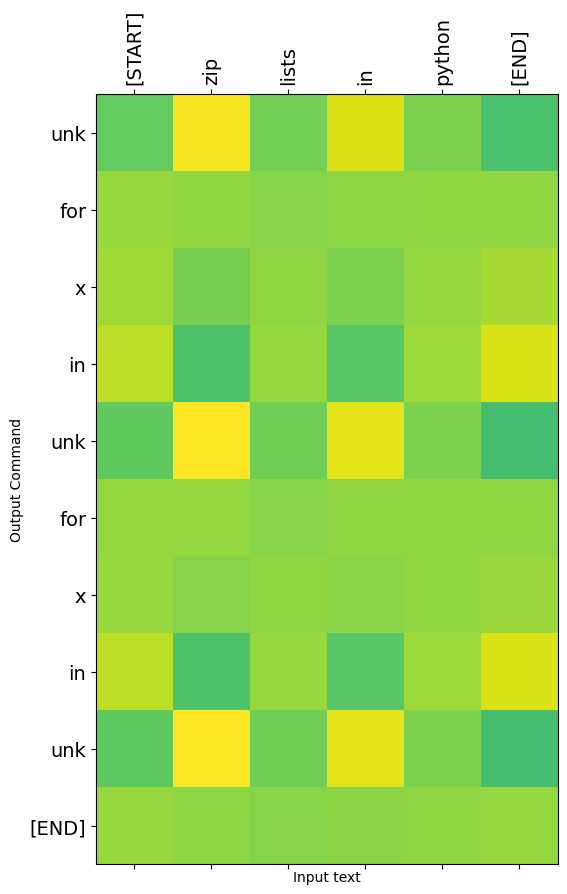

In [249]:
model.plot_attention('zip lists in python') 

In [251]:
with open('conala-test.json', 'r') as myfile:
    data=myfile.read()

# parse file
obj = json.loads(data)

test_intent_list = []
for i in range(len(obj)):
    test_intent_list.append(obj[i]['intent'])


test_snipet_list = []
for i in range(len(obj)):
    test_snipet_list.append(obj[i]['snippet'])


In [252]:
predicted=[]
actual=[]
for i in range(len(test_intent_list)):
    prediction = model.translate([test_intent_list[i]])
    prediction = prediction[0].numpy().decode()
    predicted.append(prediction)
    target_vals=test_snipet_list[i]
    actual.append(target_vals)

In [253]:
import tensorflow as tf
from nltk.translate.bleu_score import corpus_bleu 
print(corpus_bleu([[i] for i in actual], predicted))

0.0272280990824675


In [254]:
import collections
import math


def _get_ngrams(segment, max_order):
  """Extracts all n-grams upto a given maximum order from an input segment.
  Args:
    segment: text segment from which n-grams will be extracted.
    max_order: maximum length in tokens of the n-grams returned by this
        methods.
  Returns:
    The Counter containing all n-grams upto max_order in segment
    with a count of how many times each n-gram occurred.
  """
  ngram_counts = collections.Counter()
  for order in range(1, max_order + 1):
    for i in range(0, len(segment) - order + 1):
      ngram = tuple(segment[i:i+order])
      ngram_counts[ngram] += 1
  return ngram_counts


def compute_bleu(reference_corpus, translation_corpus, max_order=4,
                 smooth=False):
  """Computes BLEU score of translated segments against one or more references.
  Args:
    reference_corpus: list of lists of references for each translation. Each
        reference should be tokenized into a list of tokens.
    translation_corpus: list of translations to score. Each translation
        should be tokenized into a list of tokens.
    max_order: Maximum n-gram order to use when computing BLEU score.
    smooth: Whether or not to apply Lin et al. 2004 smoothing.
  Returns:
    3-Tuple with the BLEU score, n-gram precisions, geometric mean of n-gram
    precisions and brevity penalty.
  """
  matches_by_order = [0] * max_order
  possible_matches_by_order = [0] * max_order
  reference_length = 0
  translation_length = 0
  for (references, translation) in zip(reference_corpus,
                                       translation_corpus):
    reference_length += min(len(r) for r in references)
    translation_length += len(translation)

    merged_ref_ngram_counts = collections.Counter()
    for reference in references:
      merged_ref_ngram_counts |= _get_ngrams(reference, max_order)
    translation_ngram_counts = _get_ngrams(translation, max_order)
    overlap = translation_ngram_counts & merged_ref_ngram_counts
    for ngram in overlap:
      matches_by_order[len(ngram)-1] += overlap[ngram]
    for order in range(1, max_order+1):
      possible_matches = len(translation) - order + 1
      if possible_matches > 0:
        possible_matches_by_order[order-1] += possible_matches

  precisions = [0] * max_order
  for i in range(0, max_order):
    if smooth:
      precisions[i] = ((matches_by_order[i] + 1.) /
                       (possible_matches_by_order[i] + 1.))
    else:
      if possible_matches_by_order[i] > 0:
        precisions[i] = (float(matches_by_order[i]) /
                         possible_matches_by_order[i])
      else:
        precisions[i] = 0.0

  if min(precisions) > 0:
    p_log_sum = sum((1. / max_order) * math.log(p) for p in precisions)
    geo_mean = math.exp(p_log_sum)
  else:
    geo_mean = 0

  ratio = float(translation_length) / reference_length

  if ratio > 1.0:
    bp = 1.
  else:
    bp = math.exp(1 - 1. / ratio)

  bleu = geo_mean * bp

  return (bleu, precisions, bp, ratio, translation_length, reference_length)


In [255]:
bleu, precisions, bp, ratio, translation_length, reference_length = compute_bleu(actual, predicted, max_order=4,smooth=False)

In [256]:
print(bleu, precisions, bp, ratio, translation_length, reference_length)

0.0 [0.12298032649644203, 0.0, 0.0, 0.0] 1.0 23.89 11945 500
